# Wolf-Sheep Predation Model - Quick Start

This notebook demonstrates the **Wolf-Sheep Predation Model**, a classic predator-prey system showcasing ABSESpy's agent-based modeling capabilities.

> **📁 Location**: `examples/wolf_sheep/wolf_sheep_quick_start.ipynb`  
> **📝 Full Model**: `examples/wolf_sheep/model.py`  
> **⚙️ Configuration**: `examples/wolf_sheep/config.yaml`
> **📚 Model Documentation**: `examples/wolf_sheep/README.md`  

## Features Demonstrated

- **Agent Lifecycle**: Birth, death, reproduction
- **Spatial Movement**: Random movement patterns
- **Inter-agent Interactions**: Predation (wolf → sheep)
- **Cell-agent Interactions**: Grazing (sheep → grass)
- **Energy-based Dynamics**: Agents consume and gain energy
- **Batch Operations**: Using `shuffle_do()` and `move_to()`
- **Dynamic Plotting**: `module.attr.plot()` for visualization
- **Automatic Data Collection**: `reports` section in config.yaml

## Model Overview

This ecosystem simulation contains:

- **🌿 Grass**: Can be eaten and regrows after countdown
- **🐑 Sheep**: Graze on grass for energy, reproduce
- **🐺 Wolves**: Hunt sheep for energy, reproduce

**Rules**:
- Energy consumption: -1 per tick
- Feeding gains: +3 (sheep eating grass), +10 (wolves eating sheep)
- Death: when energy ≤ 0
- Reproduction: based on probability


## 1. Import and Setup


In [1]:
import hydra

# Import the model from local directory
from model import Sheep, Wolf, WolfSheepModel

# Load configuration from config.yaml using Hydra
# This matches how model.py loads its configuration
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose(config_name="config")

## 2. Create and Run a Simple Simulation


In [2]:
# Create the model using Hydra config
# The config is automatically parsed by ABSESpy's MainModel
model = WolfSheepModel(parameters=cfg)

print("Model initialized:")
print(f"  Grid size: {model.nature.shape2d}")
print(f"  Initial sheep: {model.n_sheep}")
print(f"  Initial wolves: {model.n_wolves}")

Model initialized:
  Grid size: (30, 30)
  Initial sheep: 50
  Initial wolves: 10


## 3. Visualize Initial State


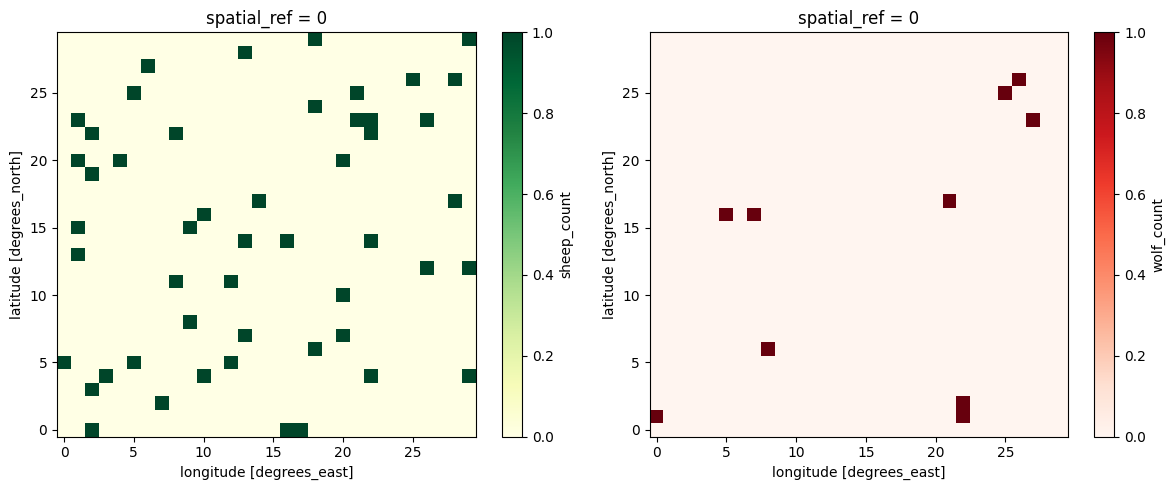

In [3]:
import matplotlib.pyplot as plt

# Plot agent distributions using the dynamic plotting API
# NEW: Visualize where agents are located on the grid!

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot sheep distribution
model.nature.count_agents(Sheep).plot(
    ax=axes[0],
    cmap="YlGn",  # Yellow-Green for sheep
)

# Plot wolves distribution
model.nature.count_agents(Wolf).plot(
    ax=axes[1],
    cmap="Reds",  # Red for wolves
)

plt.tight_layout()
plt.show()

## 4. Run Simulation and Track Progress


Running simulation for 200 steps...
Initial: 50 sheep, 10 wolves
Final: 137 sheep, 1 wolves


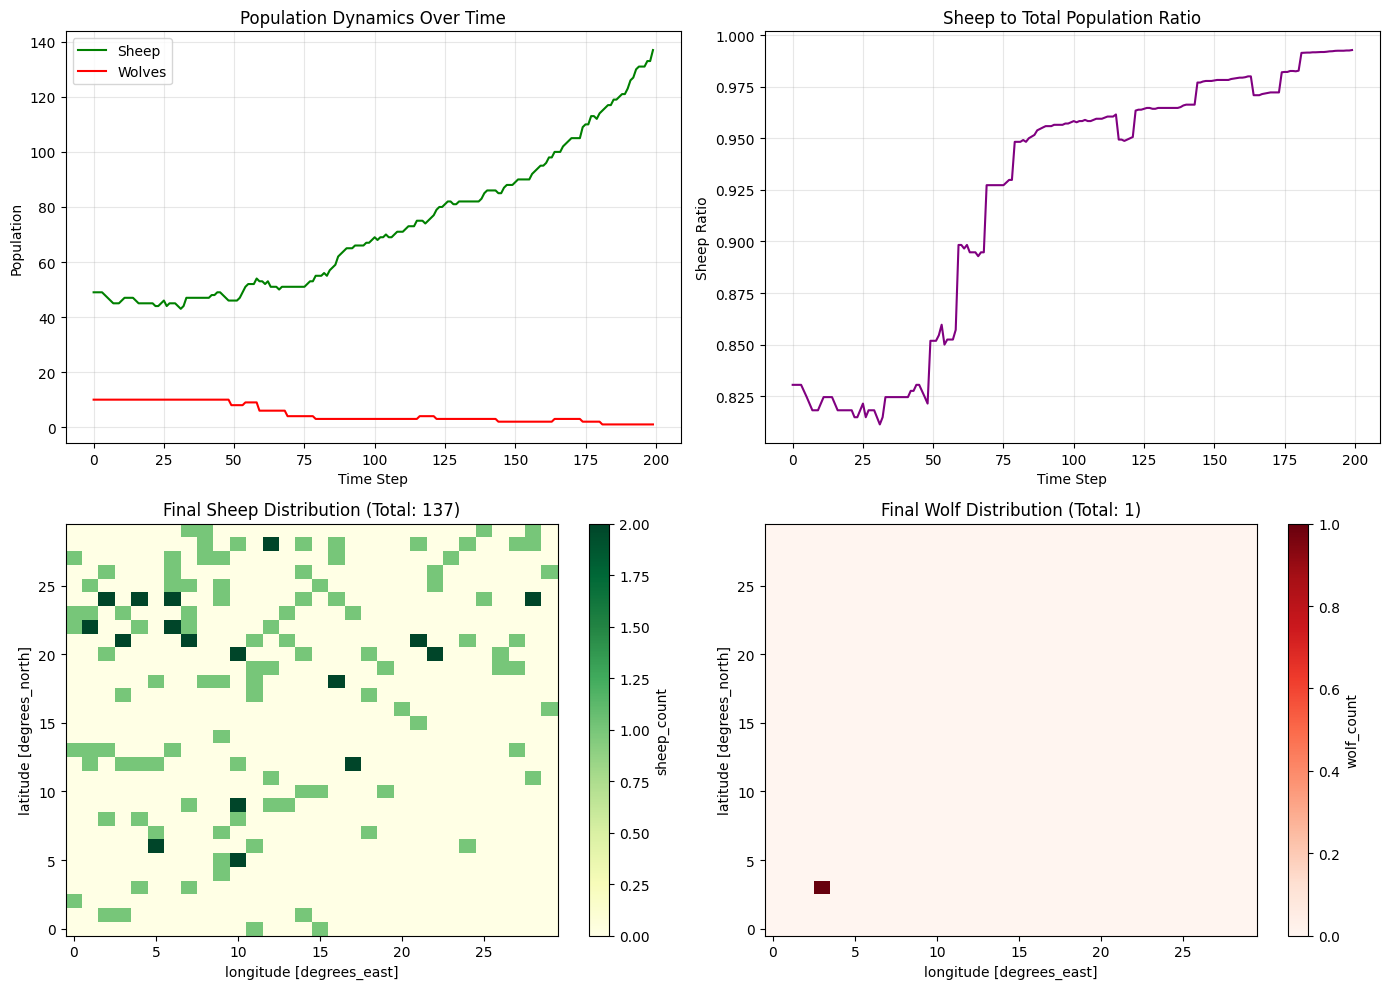


Data collected:
          n_sheep    n_wolves  population_ratio  grass_coverage
count  200.000000  200.000000        200.000000      200.000000
mean    72.455000    4.895000          0.921853        0.752594
std     25.824455    3.322525          0.064915        0.066113
min     43.000000    1.000000          0.811321        0.604444
25%     49.000000    3.000000          0.851389        0.709444
50%     68.000000    3.000000          0.956522        0.758889
75%     88.250000    9.000000          0.972028        0.810000
max    137.000000   10.000000          0.992754        0.946667


In [4]:
# Run simulation for 200 steps at once
print("Running simulation for 200 steps...")
print(f"Initial: {model.n_sheep} sheep, {model.n_wolves} wolves")

model.run_model(steps=200)

print(f"Final: {model.n_sheep} sheep, {model.n_wolves} wolves")

# Access collected data from DataCollector
collected_data = model.datacollector.get_model_vars_dataframe()

# Visualize population dynamics over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot population dynamics
axes[0, 0].plot(collected_data["n_sheep"], label="Sheep", color="green")
axes[0, 0].plot(collected_data["n_wolves"], label="Wolves", color="red")
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Population")
axes[0, 0].set_title("Population Dynamics Over Time")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot population ratio
axes[0, 1].plot(collected_data["population_ratio"], color="purple")
axes[0, 1].set_xlabel("Time Step")
axes[0, 1].set_ylabel("Sheep Ratio")
axes[0, 1].set_title("Sheep to Total Population Ratio")
axes[0, 1].grid(True, alpha=0.3)

# Final agent distribution - Sheep
sheep_map = model.nature.grassland.count_agents(Sheep, dtype="xarray")
sheep_map.plot(ax=axes[1, 0], cmap="YlGn", add_colorbar=True)
axes[1, 0].set_title(f"Final Sheep Distribution (Total: {model.n_sheep})")

# Final agent distribution - Wolves
wolf_map = model.nature.grassland.count_agents(Wolf, dtype="xarray")
wolf_map.plot(ax=axes[1, 1], cmap="Reds", add_colorbar=True)
axes[1, 1].set_title(f"Final Wolf Distribution (Total: {model.n_wolves})")

plt.tight_layout()
plt.show()

print("\nData collected:")
print(collected_data.describe())

## 5. Batch Experiment: Testing Different Initial Populations

**Experimental Design:**

How do different initial wolf populations affect ecosystem stability?

We'll test initial wolf counts from 5 to 25, keeping sheep at 50 and running until either wolves or sheep die out.

In [5]:
from abses import Experiment

# Use the same config but override for batch experiments
cfg_exp = cfg.copy()  # Start with loaded config

# Modify for batch experiment
cfg_exp.model.shape = [20, 20]  # Smaller grid for faster experiments
cfg_exp.model.n_sheep = 30
cfg_exp.model.n_wolves = 5
cfg_exp.model.rep_rate = 0.01
cfg_exp.time.end = 50
cfg_exp.reports.final = {"n_sheep": "n_sheep", "n_wolves": "n_wolves"}

# Create experiment
exp = Experiment.new(model_cls=WolfSheepModel, cfg=cfg_exp, seed=42)

# Test different wolf populations
wolf_counts = [5, 10, 15, 20]

print(f"Testing {len(wolf_counts)} different initial wolf populations...")
print(f"Wolf counts: {wolf_counts}")
print(f"Each run will use rep_rate={cfg_exp.model.rep_rate}")

# Run batch experiments
exp.batch_run(
    overrides={"model.n_wolves": wolf_counts},
    repeats=2,  # 2 runs for each configuration
    parallels=2,  # Use 2 parallel processes
)

print("\nExperiments completed!")

Testing 4 different initial wolf populations...
Wolf counts: [5, 10, 15, 20]
Each run will use rep_rate=0.01


4 jobs (repeats 2 times each).:   0%|          | 0/4 [00:00<?, ?it/s]


Experiments completed!


### 6.1 Analyze Results


In [6]:
# Get experiment results
results = exp.summary()

# Check what columns are available
print("Available columns:", results.columns.tolist())
print("\nFirst few rows:")
results.head(10)

Available columns: ['job_id', 'repeat_id', 'model.n_wolves', 'seed', 'n_sheep', 'n_wolves']

First few rows:


,job_id,repeat_id,model.n_wolves,seed,n_sheep,n_wolves
0,0,1,5,165578901,32,6
1,0,2,5,3702419103,31,5
2,1,1,10,1561874393,15,10
3,1,2,10,3426936198,13,12
4,2,1,15,2653697244,14,16
5,2,2,15,3975685604,10,22
6,3,1,20,2387470936,8,21
7,3,2,20,954070537,7,26


### 6.2 Visualize Results


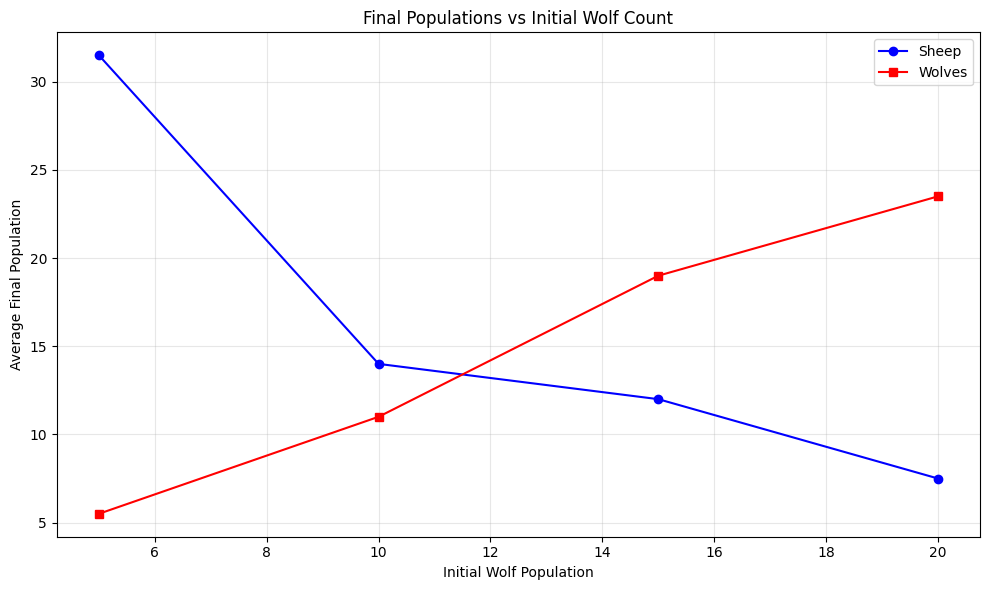

In [7]:
# Check results and plot based on available columns
if len(results) > 0:
    # Aggregate results by wolf count
    # Results may have capitalized column names
    if "n_sheep" in results.columns and "n_wolves" in results.columns:
        col_sheep, col_wolves = "n_sheep", "n_wolves"
    elif "Sheep" in results.columns and "Wolves" in results.columns:
        col_sheep, col_wolves = "Sheep", "Wolves"
    elif "sheep" in results.columns and "wolves" in results.columns:
        col_sheep, col_wolves = "sheep", "wolves"
    else:
        print("Available columns:", results.columns.tolist())
        col_sheep, col_wolves = results.columns[0], results.columns[1]

    grouped = (
        results.groupby("model.n_wolves")
        .agg({col_sheep: "mean", col_wolves: "mean"})
        .reset_index()
    )

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        grouped["model.n_wolves"], grouped[col_sheep], "o-", label="Sheep", color="blue"
    )
    ax.plot(
        grouped["model.n_wolves"],
        grouped[col_wolves],
        "s-",
        label="Wolves",
        color="red",
    )

    ax.set_xlabel("Initial Wolf Population")
    ax.set_ylabel("Average Final Population")
    ax.set_title("Final Populations vs Initial Wolf Count")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No results to plot")

## 7. Key ABSESpy Features Used

This model demonstrates several powerful ABSESpy features:

| Feature | Usage | Benefit |
|---------|-------|---------|
| **Batch Operations** | `cells_lst.shuffle_do("grow")` | Efficient cell updates |
| **Agent Movement** | `agents.shuffle_do("move_to", ...)` | Batch agent placement |
| **Raster Attributes** | `@raster_attribute` decorator | Spatial data extraction |
| **Dynamic Plotting** | `module.empty.plot()` | Fluent visualization API |
| **Agent Lifecycle** | `agent.die()` | Automatic cleanup |
| **Cell-agent Access** | `agent.at.property` | Direct environment access |
| **Agent Filtering** | `agents.select(agent_type=...)` | Conditional operations |
| **Experiment Class** | `Experiment.new()` / `batch_run()` | Parameter sweeps |

## Summary

This predator-prey model showcases:

- ✅ **Agent-based modeling**: Autonomous agents with behaviors
- ✅ **Spatial dynamics**: Grid-based interactions
- ✅ **Energy systems**: Resource consumption and reproduction
- ✅ **Emergent patterns**: Population dynamics from simple rules
- ✅ **Batch operations**: Efficient large-scale simulations
- ✅ **Experiment framework**: Systematic parameter exploration
